# MC-PCA on detrended speleothem data

This Jupyter Notebook provides an analysis of speleothem oxygen isotope data using the Monte Carlo Principal Component Analysis (MC-PCA) method. Speleothems are cave formations that contain valuable climate information, and the oxygen isotope composition of speleothems can provide insights into past climate conditions.

The notebook utilizes various Python libraries such as pandas, numpy, matplotlib, seaborn, and pyleoclim to import, process, and analyze the speleothem data. The MC-PCA method is implemented using custom classes, including MultipleEnsembleGeoSeries and MultipleMultivarDecomp, which facilitate the analysis of multiple speleothem records simultaneously. These classes will be incorporated into [Pyleoclim](https://pyleoclim-util.readthedocs.io/).

The notebook includes cells that import necessary modules, load the speleothem data from a pickle file, define variables, and perform data visualization and analysis. The data is organized into different sets, such as EA_set and IB_set, representing speleothems from different regions. The MC-PCA method allows for the decomposition of the data into principal components, which can reveal underlying patterns and trends in the oxygen isotope data.

In [22]:
import pickle

from tqdm import tqdm

import pyleoclim as pyleo
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from matplotlib import cm
from matplotlib.gridspec import GridSpec

In [23]:
with open('../data/preprocessed_ens_dict.pkl','rb') as handle: #Using un preprocessed data
    ens_dict = pickle.load(handle)

#Separating spels into two sets. Exclude Mawmluh for PCA
EA_set = [
    'Jiuxian',
    'Xianglong',
    'Heshang',
    'Lianhua',
    'Dongge',
#    'Guizhouxinv',
    'Jiulong',
    'Liuli',
]

IB_set = [
    'Sahiya',
    'Hoq',
    'Tangga',
    'Oman',
    'LaVierge'
]

all_set = EA_set + IB_set

In [489]:
import numpy as np
import scipy as sp
class MultipleMultivarDecomp():
    def __init__(self, pca_list,label=None):
        self.pca_list = pca_list
        self.label = label

    def modeplot(self,index=0,flip=False,plot_envelope_kwargs = None, psd_envelope_kwargs = None,
                 figsize=[8, 8], fig=None, savefig_settings=None,gs=None,
                 title=None, title_kwargs=None, spec_method='mtm', cmap='coolwarm',
                 marker=None, scatter_kwargs=None,
                 map_kwargs=None, gridspec_kwargs=None,quantiles=[.25,.5,.75]):
        '''Plot relevant information about the specific mode
        
        Parameters
        ----------
        
        index : int
            The 0-based index of the mode to visualize.
            Default is 0, corresponding to the first mode.
            
        flip : bool
            Whether or not to flip the PC
            
        plot_envelope_kwargs : dict
            Dictionary of key word arguments for plot envelope

        plot_envelope_kwargs : dict
            Dictionary of key word arguments for psd envelope
            
        figsize : list, optional
            The figure size. The default is [8, 8].

        savefig_settings : dict
            the dictionary of arguments for plt.savefig(); some notes below:
            - "path" must be specified; it can be any existed or non-existed path,
              with or without a suffix; if the suffix is not given in "path", it will follow "format"
            - "format" can be one of {"pdf", "eps", "png", "ps"}

        title : str, optional
            text for figure title

        title_kwargs : dict
            the keyword arguments for ax.set_title()

        gs : matplotlib.gridspec object, optional
            Requires at least two rows and two columns.
            - top row, left: timeseries of principle component
            - top row, right: PSD
            - bottom row: spaghetti plot or map
            See [matplotlib.gridspec.GridSpec](https://matplotlib.org/stable/tutorials/intermediate/gridspec.html) for details.

        gridspec_kwargs : dict, optional
            Dictionary with custom gridspec values.
            - wspace changes space between columns (default: wspace=0.05)
            - hspace changes space between rows (default: hspace=0.03)
            - width_ratios: relative width of each column (default: width_ratios=[5,1,3] where middle column serves as a spacer)
            - height_ratios: relative height of each row (default: height_ratios=[2,1,5] where middle row serves as a spacer)

        spec_method: str, optional
            The name of the spectral method to be applied on the PC. Default: MTM
            Note that the data are evenly-spaced, so any spectral method that
            assumes even spacing is applicable here:  'mtm', 'welch', 'periodogram'
            'wwz' is relevant if scaling exponents need to be estimated, but ill-advised otherwise, as it is very slow.
            
        cmap: str, optional
            if 'hue' is specified, will be used for map scatter plot values.
            colormap name for the loadings (https://matplotlib.org/stable/tutorials/colors/colormaps.html)

        map_kwargs : dict, optional
            Optional arguments for map configuration
            - projection: str; Optional value for map projection. Default 'auto'.
            - proj_default: bool
            - lakes, land, ocean, rivers, borders, coastline, background: bool or dict;
            - lgd_kwargs: dict; Optional values for how the map legend is configured
            - gridspec_kwargs: dict; Optional values for adjusting the arrangement of the colorbar, map and legend in the map subplot
            - legend: bool; Whether to draw a legend on the figure. Default is True
            - colorbar: bool; Whether to draw a colorbar on the figure if the data associated with hue are numeric. Default is True
            The default is None.
            
        scatter_kwargs : dict, optional
            Optional arguments configuring how data are plotted on a map. See description of scatter_kwargs in pyleoclim.utils.mapping.scatter_map

        hue : str, optional
            (only applicable if using scatter map) Variable associated with color coding for points plotted on map. May correspond to a continuous or categorical variable.
            The default is 'EOF'.

        marker : string, optional
            (only applicable if using scatter map) Grouping variable that will produce points with different markers. Can have a numeric dtype but will always be treated as categorical.
            The default is 'archiveType'.

        quantiles : list,array
            Quantiles to use for plotting EOFs
            
        Returns
        -------

        fig : matplotlib.figure
            The figure

        ax : dict
            dictionary of matplotlib ax

        See also
        --------

        pyleoclim.core.MultipleSeries.pca : Principal Component Analysis

        pyleoclim.core.MultipleGeoSeries.pca : Principal Component Analysis
        
        pyleoclim.utils.tsutils.eff_sample_size : Effective sample size

        pyleoclim.utils.mapping.scatter_map : mapping'''

        plot_envelope_kwargs = {} if plot_envelope_kwargs is None else plot_envelope_kwargs.copy()
        psd_envelope_kwargs = {} if psd_envelope_kwargs is None else psd_envelope_kwargs.copy()
        savefig_settings = {} if savefig_settings is None else savefig_settings.copy()

        if fig ==None:
            fig = plt.figure(figsize=figsize)
            
        if gs == None:
            gridspec_kwargs = {} if type(gridspec_kwargs) != dict else gridspec_kwargs
            gridspec_defaults = dict(wspace=0.05, hspace=0.03, width_ratios=[5,1,3],
                                     height_ratios=[2,1,5])
            gridspec_defaults.update(gridspec_kwargs)
            gs = GridSpec(len(gridspec_defaults['height_ratios']), len(gridspec_defaults['width_ratios']), **gridspec_defaults)

        gs.update(left=0, right=1.1)

        ax = {}
        # plot the PC
        ax['pc'] = fig.add_subplot(gs[0, 0])
        label = rf'$PC_{index + 1}$' 

        t_list = []
        pc_list = []
        eof_array = np.empty(shape=(len(self.pca_list[0].eigvecs[:,index]),len(self.pca_list)))
        pctvar_array = np.empty(shape=len(self.pca_list))
        for idx,pca in enumerate(self.pca_list):
            if flip:
                PC = -pca.pcs[:, index]
                EOF = -pca.eigvecs[:, index]
                t = pca.orig.series_list[0].time
            else:
                PC = pca.pcs[:, index]
                EOF = pca.eigvecs[:, index]
                t = pca.orig.series_list[0].time
            t_list.append(t)
            pc_list.append(PC)
            eof_array[:,idx] = EOF
            pctvar_array[idx]= pca.pctvar[index]
        eof_quantiles = np.quantile(a=eof_array,q=quantiles,axis=1)

        time_unit = self.pca_list[0].orig.series_list[0].time_unit
        pca_ens = pyleo.EnsembleSeries([pyleo.Series(time=t_list[idx],value=pc_list[idx],time_unit=time_unit,verbose=False) for idx in range(len(self.pca_list))])

        if 'plot_legend' not in plot_envelope_kwargs.keys():
            plot_envelope_kwargs['plot_legend'] = False

        pca_ens.common_time().plot_envelope(ax=ax['pc'],**plot_envelope_kwargs)
        ax['pc'].set_ylabel(label)

        # plot its PSD
        ax['psd'] = fig.add_subplot(gs[0, -1])

        if 'plot_legend' not in psd_envelope_kwargs.keys():
            psd_envelope_kwargs['plot_legend'] = False
        if 'members_plot_num' not in psd_envelope_kwargs.keys():
            psd_envelope_kwargs['members_plot_num'] = 0

        psd = pca_ens.common_time().spectral(method=spec_method)
        _ = psd.plot_envelope(ax=ax['psd'],**psd_envelope_kwargs)

        # plot spatial pattern or spaghetti
        map_kwargs = {} if map_kwargs is None else map_kwargs.copy()

        projection = map_kwargs.pop('projection', 'auto')
        proj_default = map_kwargs.pop('proj_default', True)
        lakes = map_kwargs.pop('lakes', False)
        land = map_kwargs.pop('land', False)
        ocean = map_kwargs.pop('ocean', False)
        rivers = map_kwargs.pop('rivers', False)
        borders = map_kwargs.pop('borders', True)
        coastline = map_kwargs.pop('coastline', True)
        background = map_kwargs.pop('background', True)
        extent = map_kwargs.pop('extent', 'global')

        map_gridspec_kwargs = map_kwargs.pop('gridspec_kwargs', {})
        lgd_kwargs = map_kwargs.pop('lgd_kwargs', {})

        if 'edgecolor' in map_kwargs.keys():
            scatter_kwargs.update({'edgecolor': map_kwargs['edgecolor']})

        legend = map_kwargs.pop('legend', True)
        colorbar = map_kwargs.pop('colorbar', True)

        # This makes a bare bones dataframe from a MultipleGeoSeries object
        df_list = []
        for idx,q in enumerate(quantiles):
            eof_q = eof_quantiles[idx]
            df_tmp = pyleo.utils.mapping.make_df(self.pca_list[0].orig, hue='quantile', marker=marker, size='EOF')
            # additional columns are added manually
            df_tmp['EOF'] = np.abs(eof_q)
            df_tmp['quantile'] = q*100
            df_tmp['quantile'][eof_q<0] *= -1
            df_list.append(df_tmp)
        df = pd.concat(df_list)
        df = df.sort_values(['lat','EOF'],ascending=False)#Make sure large sizes plot first

        if legend == True:
            map_gridspec_kwargs['width_ratios'] = map_gridspec_kwargs['width_ratios'] if 'width_ratios' in map_gridspec_kwargs.keys() else [.7,.1, 12, 4]

        ax_norm = mpl.colors.Normalize(vmin=min(df['quantile'].to_numpy()), vmax=max(df['quantile'].to_numpy()), clip=False)
        ax_cmap = plt.get_cmap(name=cmap)
        ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)

        _, ax['map'] = pyleo.utils.mapping.scatter_map(df, hue='quantile', size='EOF', marker=marker, projection=projection,
                                            proj_default=proj_default,
                                            background=background, borders=borders, coastline=coastline,
                                            rivers=rivers, lakes=lakes,
                                            ocean=ocean, land=land, extent=extent,
                                            figsize=None, scatter_kwargs=scatter_kwargs, lgd_kwargs=lgd_kwargs,
                                            gridspec_kwargs=map_gridspec_kwargs, colorbar=colorbar,
                                            legend=legend, cmap=ax_sm.cmap,
                                            fig=fig, gs_slot=gs[-1, :]) #label rf'$EOF_{index + 1}$'
        ax['map']['cb'].remove()

        if title is None:
            title = self.label + ' mode ' + str(index + 1) + ', ' + '{:3.2f}'.format(pctvar_array.mean()) + u" \u00B1 " + '{:3.2f}'.format(pctvar_array.std()) + '% variance explained'
                      # weight='bold', y=0.92)

        title_kwargs = {} if title_kwargs is None else title_kwargs.copy()
        t_args = {'y': .92, 'weight': 'bold'}
        t_args.update(title_kwargs)
        fig.suptitle(title, **t_args)
        
        fig.tight_layout()
        
        if 'path' in savefig_settings:
            pyleo.utils.plotting.savefig(fig, settings=savefig_settings)

        return fig, ax
    
    def screeplot(self,quantiles=[.25,.5,.75],clr_eig='C0', linewidth=.3, title='Screeplot', violin_kwargs = None, figsize=[8, 8],savefig_settings=None,ax=None):
        '''Function to plot the scree plot of the PCA
        
        Parameters
        ----------

        quantiles : list,array
            Quantiles to use for plotting range of pctvar for each mode.

        clr_eig : str
            Color to use for the eigenvalues. Default is 'C0'.

        linewidth : float
            Linewidth to use for the violin plot. Default is 0.3.

        violin_kwargs : dict
            Dictionary of key word arguments for violin plot.
            If exposed plot arguments {'color','linewidth','title'} are included in kwargs, kwargs will overwrite the exposed argument values.
        
        figsize : list, optional
            The figure size. The default is [8, 8].
            
        savefig_settings : dict
            the dictionary of arguments for plt.savefig(); some notes below:
            - "path" must be specified; it can be any existed or non-existed path,
              with or without a suffix; if the suffix is not given in "path", it will follow "format"
            - "format" can be one of {"pdf", "eps", "png", "ps"}

        ax : matplotlib.axis, optional
            the axis object from matplotlib
            See [matplotlib.axes](https://matplotlib.org/api/axes_api.html) for details.
            
        Returns
        -------
        
        fig : matplotlib.figure
            The figure
        
        ax : dict
            dictionary of matplotlib ax'''
        
        violin_kwargs = {} if violin_kwargs is None else violin_kwargs.copy()
        savefig_settings = {} if savefig_settings is None else savefig_settings.copy()
        
        if ax is None:
            fig,ax = plt.subplots(figsize=figsize)

        modes = np.arange(len(self.pca_list[0].pctvar))
        pctvar_array = np.empty(shape=(len(modes),len(self.pca_list)))

        for mode in modes:
            pctvar_array[mode,:] = np.array([pca.pctvar[mode] for pca in self.pca_list])

        # pctvar_quantiles = np.quantile(a=pctvar_array,q=quantiles,axis=1)

        if 'color' in violin_kwargs.keys():
            clr_eig = violin_kwargs.pop('color')

        if 'linewidth' in violin_kwargs.keys():
            linewidth = violin_kwargs.pop('linewidth')
        
        sns.violinplot(pctvar_array.T,linewidth=linewidth,color=clr_eig,figsize=(8,8),ax=ax,**violin_kwargs)
        ax.set_xlabel(r'Mode index $i$')
        ax.set_ylabel(r'$\lambda_i$')

        if title:
            ax.set_title(title)
        
        if 'path' in savefig_settings:
            pyleo.utils.plotting.savefig(fig, settings=savefig_settings)
        
        return fig, ax
    
class MultipleEnsembleGeoSeries():
    def __init__(self, ensemble_series_list,label=None):
        self.ensemble_series_list = ensemble_series_list
        self.label = label

    def mcpca(self,nsim=1000, seed=None, common_time_kwargs=None, pca_kwargs=None,align_method='dot',delta=0,phase_max=.5):
        '''Function to conduct Monte-Carlo PCA using ensembles included in this object
        
        Parameters
        ----------
        
        nsim : int
            Number of simulations to carry out. Default is 1000
            
        seed : int
            Seed to use for random calculations
            
        common_time_kwargs : dict
            Key word arguments for MultipleSeries.common_time()
            
        pca_kwargs : dict
            Key word arguments for MultipleGeoSeries.pca()

        align_method : str; {'correlation','dot','phase','cosine'}
            How to align pcs. 
            Correlation computes the correlation between individual principal components and the first set of PCs, flipping those that have a negative correlation.
            Dot computes the dot product between the eigenvectors, and flips those that have a negative dot product.
            Phase computes the phase difference between the eigenvectors, and flips those that have a phase difference greater than phase_max.
            Cosine computes the cosine similarity between the eigenvectors, and flips those that have a negative cosine similarity.

        delta : float
            A number between -1 and 1, that serves as the threshold for the correlation, dot, and cosine methods. Default is 0.

        phase_max : float
            A float between 0 and 1, that serves as the threshold for the phase method. Default is 0.5.
            
        Returns
        -------
        
        MultipleMvD : pyleo.MultipleMultivarDecomp
            Multiple Multivariate Decomposition object'''
        
        common_time_kwargs = {} if common_time_kwargs is None else common_time_kwargs.copy()
        pca_kwargs = {} if pca_kwargs is None else pca_kwargs.copy()

        if seed:
            rng = np.random.default_rng(seed=seed)
        else:
            rng = np.random.default_rng()

        pca_list = []

        for i in tqdm(range(nsim),desc='Iterating over simulations'):
            ensemble_list = []
            for ensemble in self.ensemble_series_list:
                rng_index = rng.integers(low=0,high=len(ensemble.series_list))
                ensemble_list.append(ensemble.series_list[rng_index])
            mgs_tmp = pyleo.MultipleGeoSeries(ensemble_list).common_time(**common_time_kwargs)
            pca_tmp = mgs_tmp.pca(**pca_kwargs)

            #Create reference pca
            if i == 0:
                base_pca = pca_tmp
                base_pcs = pca_tmp.pcs
                base_t = pca_tmp.orig.series_list[0].time
                base_eigvecs = pca_tmp.eigvecs.T
                pca_list.append(pca_tmp)
                continue

            if align_method == 'correlation':
                for idx,pcs in enumerate(pca_tmp.pcs.T):
                    t = pca_tmp.orig.series_list[0].time
                    pc_series = pyleo.Series(time=t,value=pcs,verbose=False)
                    base_pc_series = pyleo.Series(time=base_t,value=base_pcs[:,idx],verbose=False)
                    r = pc_series.correlation(base_pc_series,settings={'nsim':1},seed=seed,mute_pbar=True).r
                    if r > delta:
                        pass
                    else:
                        pca_tmp.eigvecs[:,idx] *= -1
                        pca_tmp.pcs[:,idx] *= -1
            elif align_method == 'phase':
                for idx,pcs in enumerate(pca_tmp.pcs.T):
                    t = pca_tmp.orig.series_list[0].time
                    pc_series = pyleo.Series(time=t,value=pcs,verbose=False)
                    base_pc_series = pyleo.Series(time=base_t,value=base_pcs[:,idx],verbose=False)
                    filtered_pcs = pc_series.filter(method='lanczos',cutoff_freq=.005)
                    filtered_base_pcs = base_pc_series.filter(method='lanczos',cutoff_freq=.005)
                    correlation = sp.signal.correlate(filtered_base_pcs.value, filtered_pcs.value, mode="full")
                    lags = sp.signal.correlation_lags(filtered_base_pcs.value.size, filtered_pcs.value.size, mode="full")
                    shift = np.abs(lags[np.argmax(correlation)])/(len(lags)/2)
                    # plt.plot(np.linspace(-180,180,len(correlation)),correlation)
                    if shift < phase_max:
                        pass
                    else:
                        pca_tmp.eigvecs[:,idx] *= -1
                        pca_tmp.pcs[:,idx] *= -1
            elif align_method == 'dot':
                for idx,eigvecs in enumerate(pca_tmp.eigvecs.T):
                    dot = np.dot(eigvecs,base_eigvecs[idx])
                    if dot > delta:
                        pass
                    else:
                        pca_tmp.eigvecs[:,idx] *= -1
                        pca_tmp.pcs[:,idx] *= -1
            elif align_method == 'cosine':
                for idx,eigvecs in enumerate(pca_tmp.eigvecs.T):
                    cos = sp.spatial.distance.cosine(eigvecs,base_eigvecs[idx])
                    if cos > delta:
                        pass
                    else:
                        pca_tmp.eigvecs[:,idx] *= -1
                        pca_tmp.pcs[:,idx] *= -1
            else:
                raise ValueError('Align method not recognized. Please pass "phase", "cosine", "correlation", or "dot".')

            pca_list.append(pca_tmp)

        # assign name
        if self.label is not None:
            label = self.label + ' PCA'
        else:
            label = 'PCA of unlabelled object'

        MultipleMvD = MultipleMultivarDecomp(pca_list=pca_list,label=label)
        return MultipleMvD


First we'll analyze all of the speleothems together:

In [321]:
# creating a multipleensemblegeoseries, slicing each record to focus on the 3000 to 5000 interval
megs = MultipleEnsembleGeoSeries(list(ens_dict[label].slice((3000,5000)) for label in all_set),label="All Speleothems")

In [339]:
# applying mcpca
megs_pca = megs.mcpca(seed=42,align_method='dot')

Iterating over simulations: 100%|██████████| 1000/1000 [00:04<00:00, 204.23it/s]


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Screeplot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

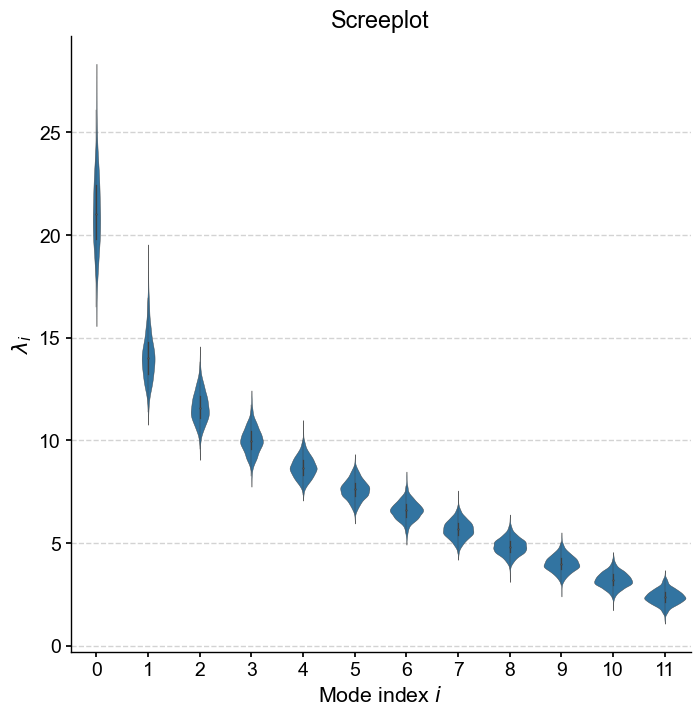

In [340]:
#generating the screeplot
megs_pca.screeplot()

Performing spectral analysis on individual series: 100%|██████████| 999/999 [00:03<00:00, 272.84it/s]


(5000.0, 3000.0)

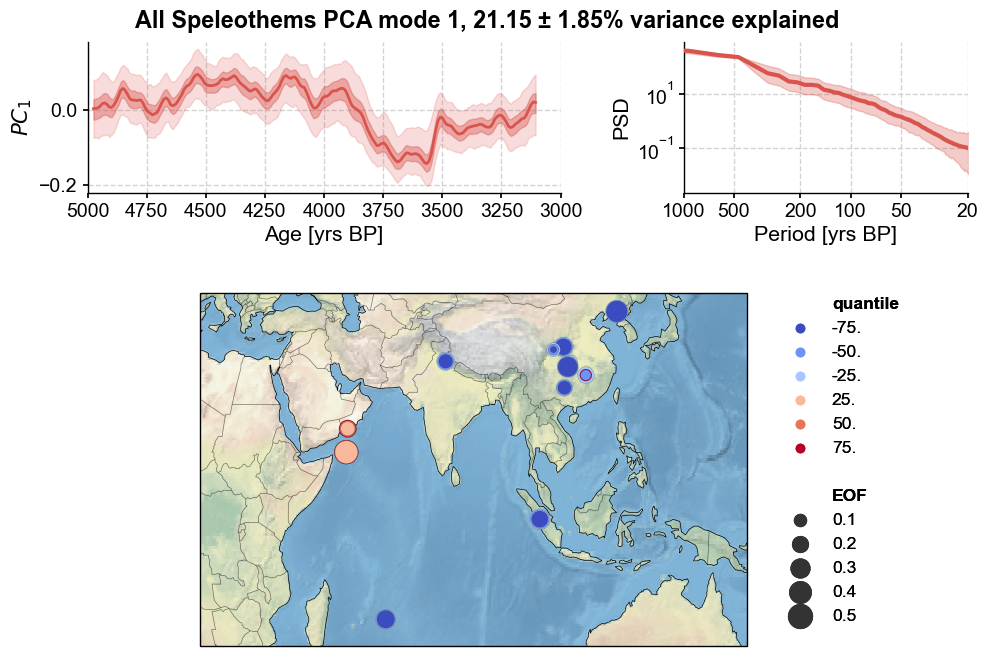

In [341]:
#plotting the first pc
fig,ax = megs_pca.modeplot(index=0,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[20,150,-25,45]})
ax['pc'].set_xlim([5000,3000])

In [342]:
pyleo.savefig(fig,'../figures/mcpca_all_detrended_1.pdf')

Figure saved at: "../../figures/mcpca_all_detrended.pdf"


Performing spectral analysis on individual series: 100%|██████████| 999/999 [00:03<00:00, 270.79it/s]


(5000.0, 3000.0)

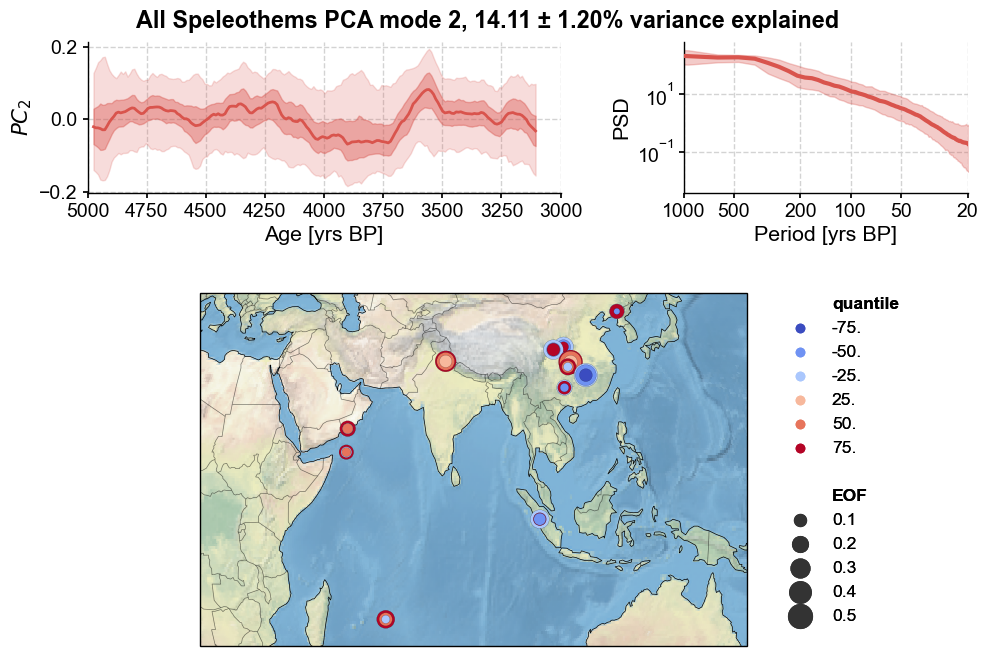

In [343]:
#plotting the second pc
fig,ax = megs_pca.modeplot(index=1,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[20,150,-25,45]})
ax['pc'].set_xlim([5000,3000])

Now we'll look at just the East Asian speleothems. Note that when we plot the envelopes for the results of MC-PCA here, there is some evidence that some principal components aren't being properly flipped. This is a work in a progress, and doesn't seem to effect the main takeaway too much.

In [514]:
megs_ea = MultipleEnsembleGeoSeries(list(ens_dict[label].slice((3000,5000)) for label in EA_set),label='East Asian Speleothems')

In [515]:
megs_ea_pca = megs_ea.mcpca(seed=42)

Iterating over simulations: 100%|██████████| 1000/1000 [00:02<00:00, 355.32it/s]


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Screeplot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

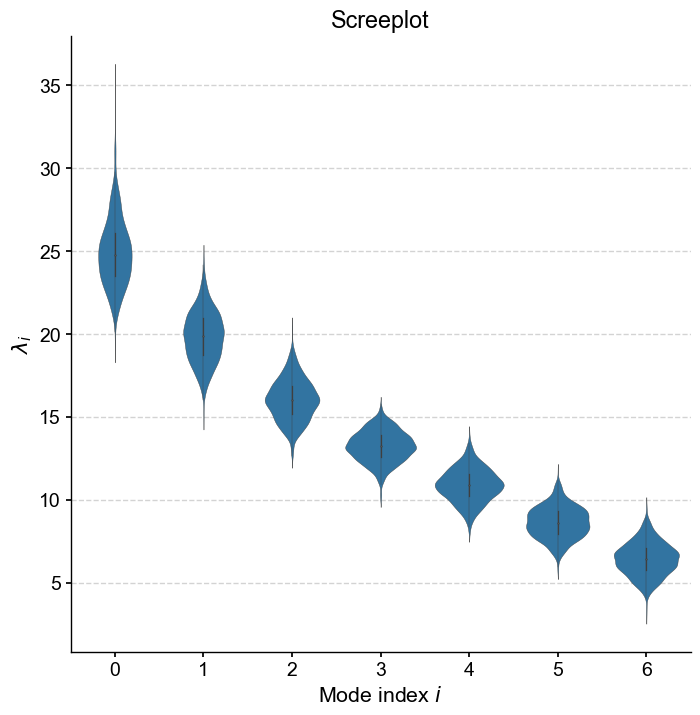

In [516]:
megs_ea_pca.screeplot()

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:03<00:00, 268.96it/s]


(5000.0, 3000.0)

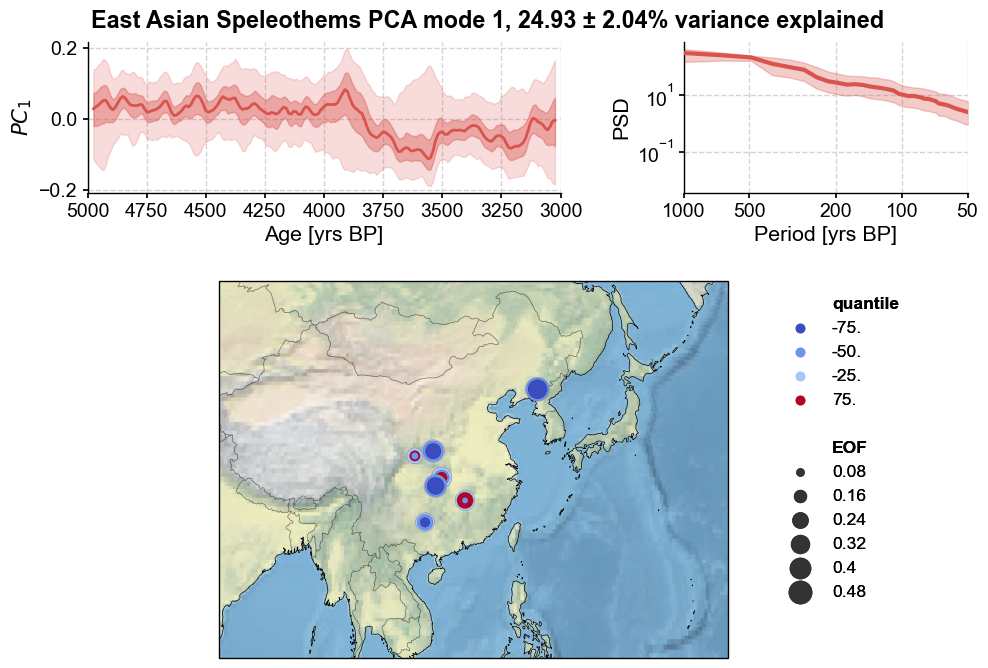

In [517]:
fig,ax = megs_ea_pca.modeplot(index=0,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[80,150,10,55]})
ax['pc'].set_xlim([5000,3000])

In [331]:
pyleo.savefig(fig,'../figures/mcpca_ea_detrended_1.pdf')

Figure saved at: "../../figures/mcpca_ea_detrended_1.pdf"


Performing spectral analysis on individual series: 100%|██████████| 999/999 [00:03<00:00, 275.85it/s]


(5000.0, 3000.0)

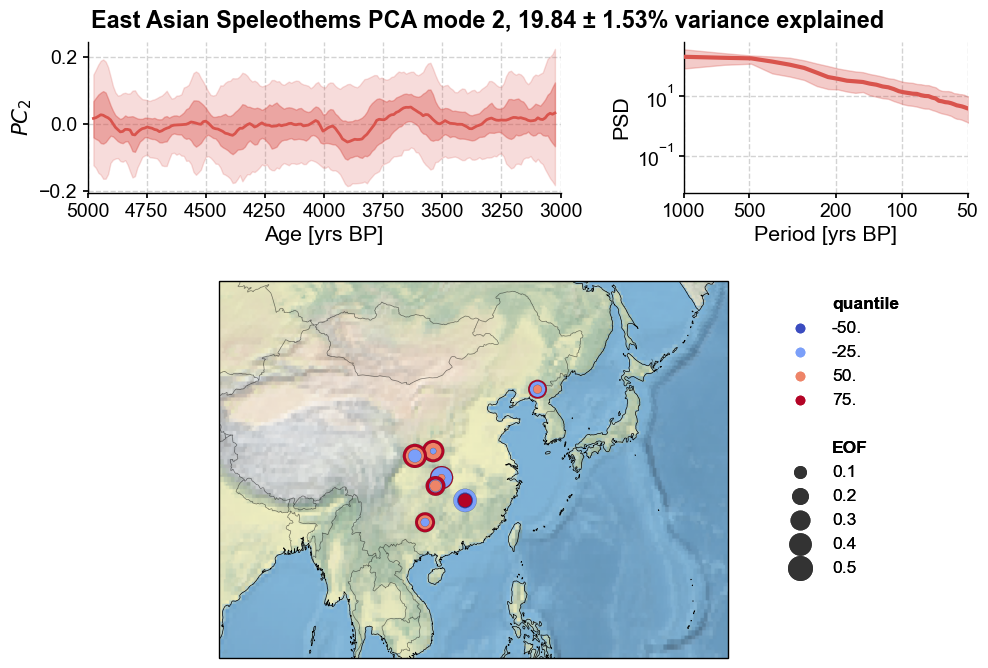

In [332]:
fig,ax = megs_ea_pca.modeplot(index=1,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[80,150,10,55]})
ax['pc'].set_xlim([5000,3000])

Now we'll look at just the Indian Ocean Basin records:

In [494]:
megs_ib = MultipleEnsembleGeoSeries(list(ens_dict[label].slice((3000,5000)) for label in IB_set),label='Indian Ocean Basin Speleothems')

In [495]:
megs_ib_pca = megs_ib.mcpca(seed=42)

Iterating over simulations: 100%|██████████| 1000/1000 [00:02<00:00, 447.01it/s]


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Screeplot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

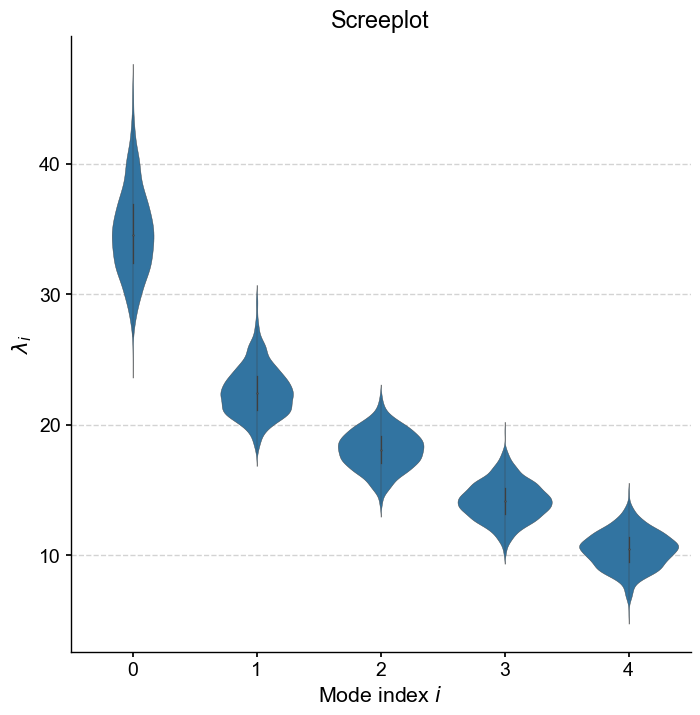

In [496]:
megs_ib_pca.screeplot()

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:04<00:00, 245.81it/s]


(5000.0, 3000.0)

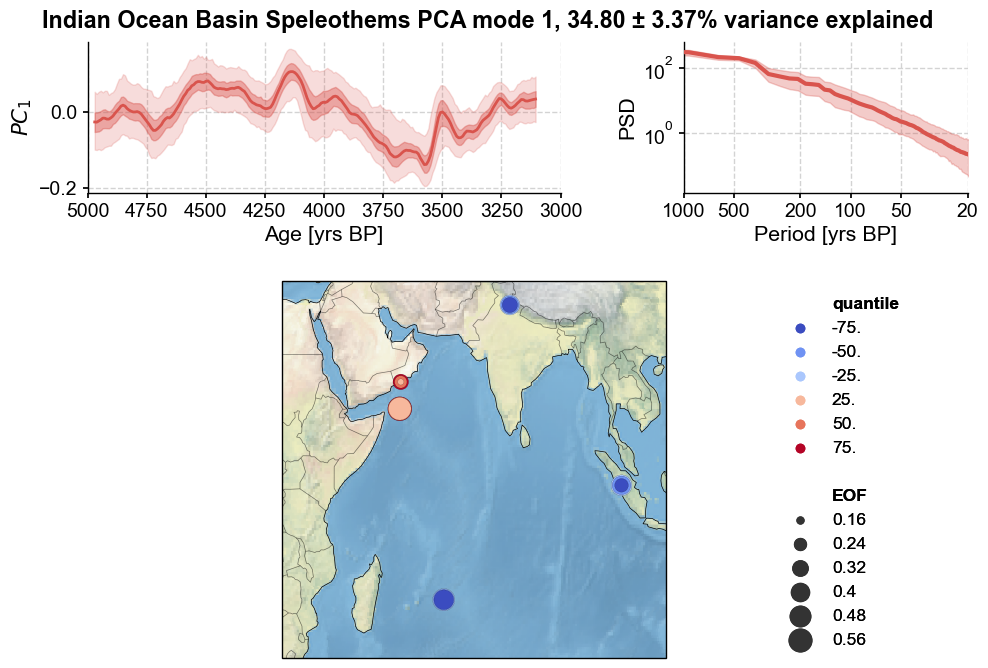

In [497]:
fig,ax = megs_ib_pca.modeplot(index=0,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[30,110,-30,35]})
ax['pc'].set_xlim([5000,3000])

In [498]:
pyleo.savefig(fig,'../figures/mcpca_ib_detrended_1.pdf')

Figure saved at: "../../figures/mcpca_ib_detrended_1.pdf"


Performing spectral analysis on individual series: 100%|██████████| 999/999 [00:04<00:00, 242.62it/s]


(5000.0, 3000.0)

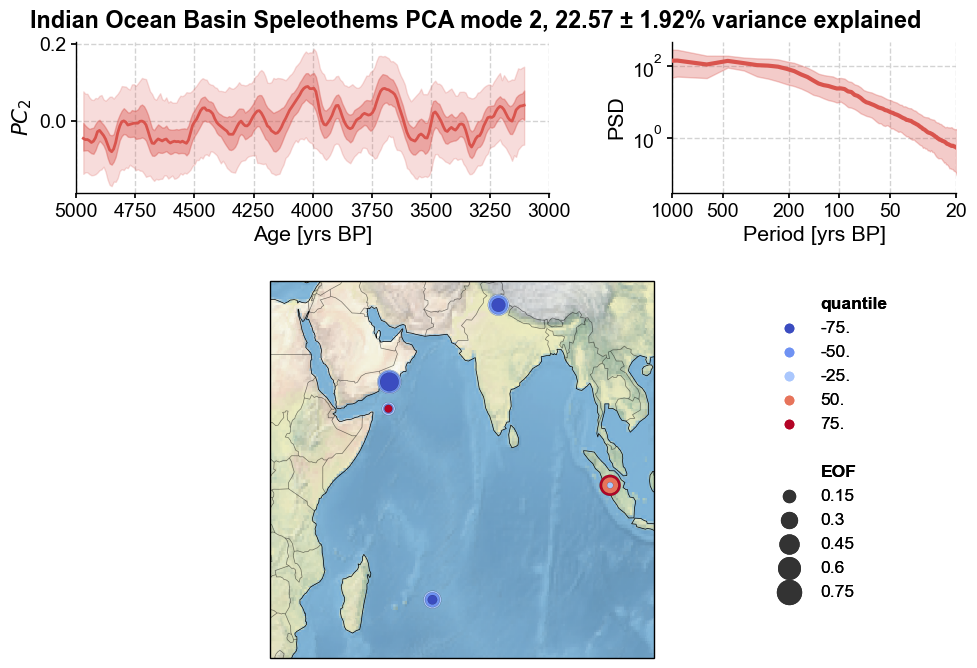

In [338]:
fig,ax = megs_ib_pca.modeplot(index=1,scatter_kwargs={'sizes':(20,300),'linewidth':.1},map_kwargs={'projection':'Mollweide','extent':[30,110,-30,35]})
ax['pc'].set_xlim([5000,3000])